In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

/home/gswt/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Input/Reference Generation

In [ ]:
os.makedirs('data', exist_ok=True)

# Generate input range
x = np.arange(-8.0, 8.0 + 0.0625, 0.0625)

# Save input (Q8.8 for testbench)
x_q88 = (x * 256).astype(int)
with open('data/input_test.csv', 'w') as f:
    f.write('x_in\n')
    for val in x_q88:
        f.write(f'{val}\n')

# Save reference
ref = pd.DataFrame({
    'x'         : x,
    'sigmoid'   : 1 / (1 + np.exp(-x)),
    'tanh'      : np.tanh(x)
})
ref.to_csv('data/output_reference.csv', index=False)

print(f'Generated {len(x)} test points')

Generated 257 test points


## Result Plots

In [ ]:
def plot_result(ref_path, out_paths, mode, xlim=None):
    """
    Plot PWL results vs reference.
    
    Args:
        ref_path: path to reference csv
        out_paths: list of (label, path) tuples for PWL outputs
        mode: 'sigmoid' or 'tanh'
        xlim: tuple (xmin, xmax) to set x-axis limits, e.g. (-4, 4)
    """
    ref = pd.read_csv(ref_path)

    colors = ['red', 'orange', 'green', 'purple']
    
    plt.figure(figsize=(8, 5))
    plt.plot(ref['x'], ref[mode], '--', label='Real', linewidth=2)
    
    for i, (label, path) in enumerate(out_paths):
        pwl = pd.read_csv(path)
        x = pwl['x_in'] / 256.0
        y = pwl['y_out'] / 256.0
        # plt.plot(x, y, 'b-', label=label, linewidth=2)
        plt.plot(x, y, 'b-', color=colors[i % len(colors)], label=label, linewidth=2)
    
    if xlim:
        plt.xlim(xlim)

    plt.xlabel('x')
    plt.ylabel(f'{mode}(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

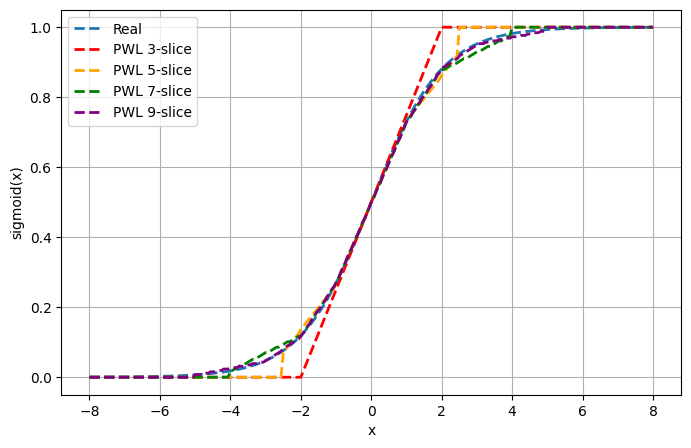

In [44]:
# Sigmoid comparison
plot_result(
    ref_path='data/output_reference.csv',
    out_paths=[
        ('PWL 3-slice', 'data/output_pwl_sigmoid_3.csv'),
        ('PWL 5-slice', 'data/output_pwl_sigmoid_5.csv'),
        ('PWL 7-slice', 'data/output_pwl_sigmoid_7.csv'),
        ('PWL 9-slice', 'data/output_pwl_sigmoid_9.csv'),
    ],
    mode='sigmoid'
)

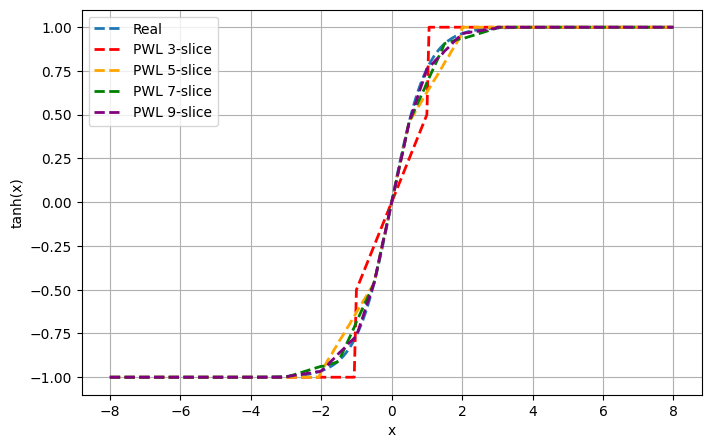

In [43]:
# Tanh comparison
plot_result(
    ref_path='data/output_reference.csv',
    out_paths=[
        ('PWL 3-slice', 'data/output_pwl_tanh_3.csv'),
        ('PWL 5-slice', 'data/output_pwl_tanh_5.csv'),
        ('PWL 7-slice', 'data/output_pwl_tanh_7.csv'),
        ('PWL 9-slice', 'data/output_pwl_tanh_9.csv'),
    ],
    mode='tanh'
)

In [40]:
def plot_result_2(ref_path, out_paths, mode, xlim=None):
    """
    Plot PWL results vs reference in 2x2 grid.
    
    Args:
        ref_path: path to reference csv
        out_paths: list of (label, path) tuples for PWL outputs (expects 4)
        mode: 'sigmoid' or 'tanh'
        xlim: tuple (xmin, xmax) to set x-axis limits, e.g. (-4, 4)
    """
    ref = pd.read_csv(ref_path)
    
    colors = ['red', 'orange', 'green', 'purple']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, (label, path) in enumerate(out_paths):
        ax = axes[i]
        
        # Plot reference
        ax.plot(ref['x'], ref[mode], 'b-', label='Real', linewidth=2)
        
        # Plot PWL
        pwl = pd.read_csv(path)
        x = pwl['x_in'] / 256.0
        y = pwl['y_out'] / 256.0
        ax.plot(x, y, '--', color=colors[i], label=label, linewidth=2)
        
        ax.set_xlabel('x')
        ax.set_ylabel(f'{mode}(x)')
        ax.set_title(label)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        if xlim:
            ax.set_xlim(xlim)
    
    fig.suptitle(f'{mode.capitalize()} Function: Real vs PWL Approximations', fontsize=14)
    plt.tight_layout()
    plt.show()

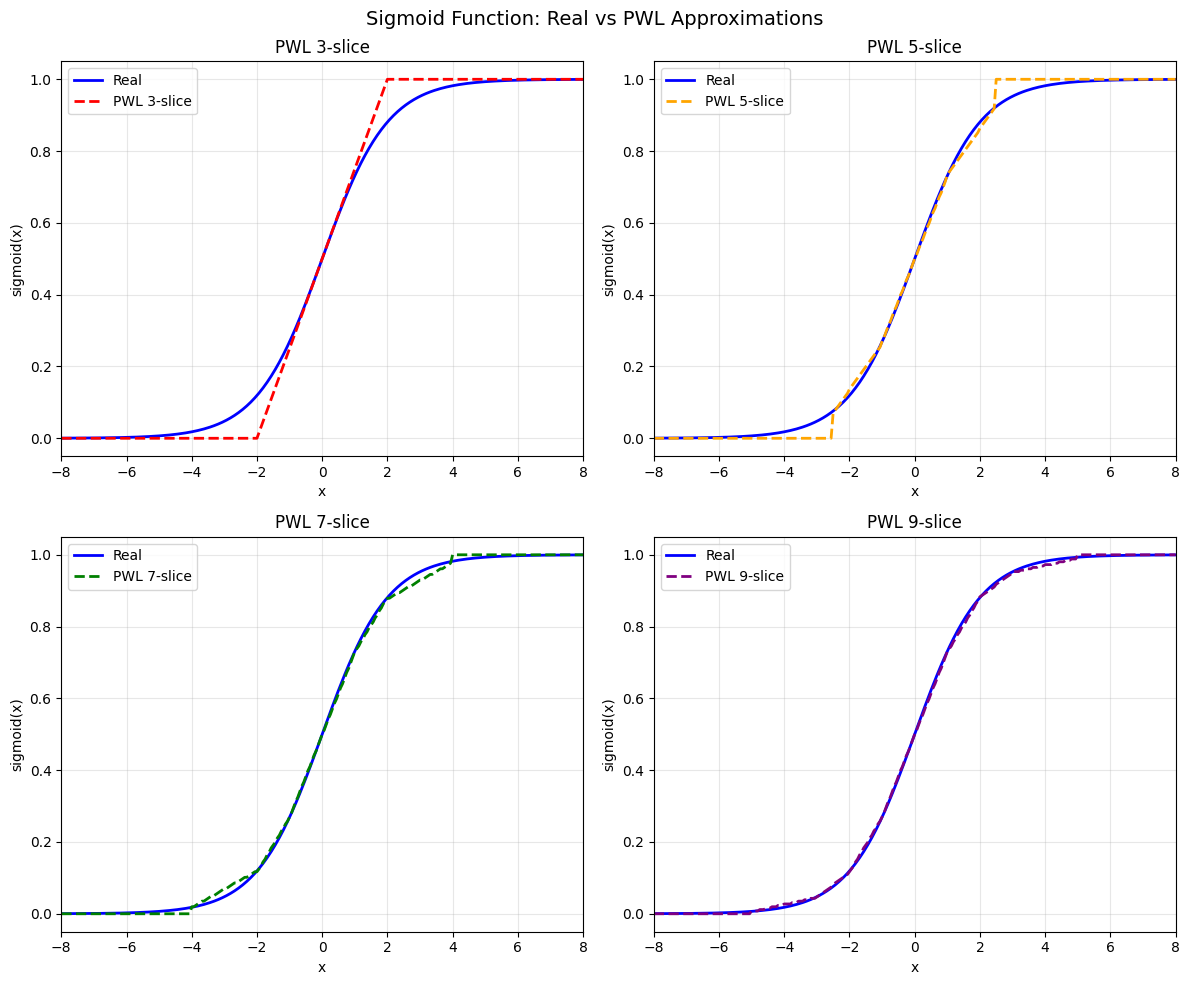

In [42]:
# Sigmoid comparison (2x2 grid)
plot_result_2(
    ref_path='data/output_reference.csv',
    out_paths=[
        ('PWL 3-slice', 'data/output_pwl_sigmoid_3.csv'),
        ('PWL 5-slice', 'data/output_pwl_sigmoid_5.csv'),
        ('PWL 7-slice', 'data/output_pwl_sigmoid_7.csv'),
        ('PWL 9-slice', 'data/output_pwl_sigmoid_9.csv'),
    ],
    mode='sigmoid',
    xlim=(-8, 8)

)

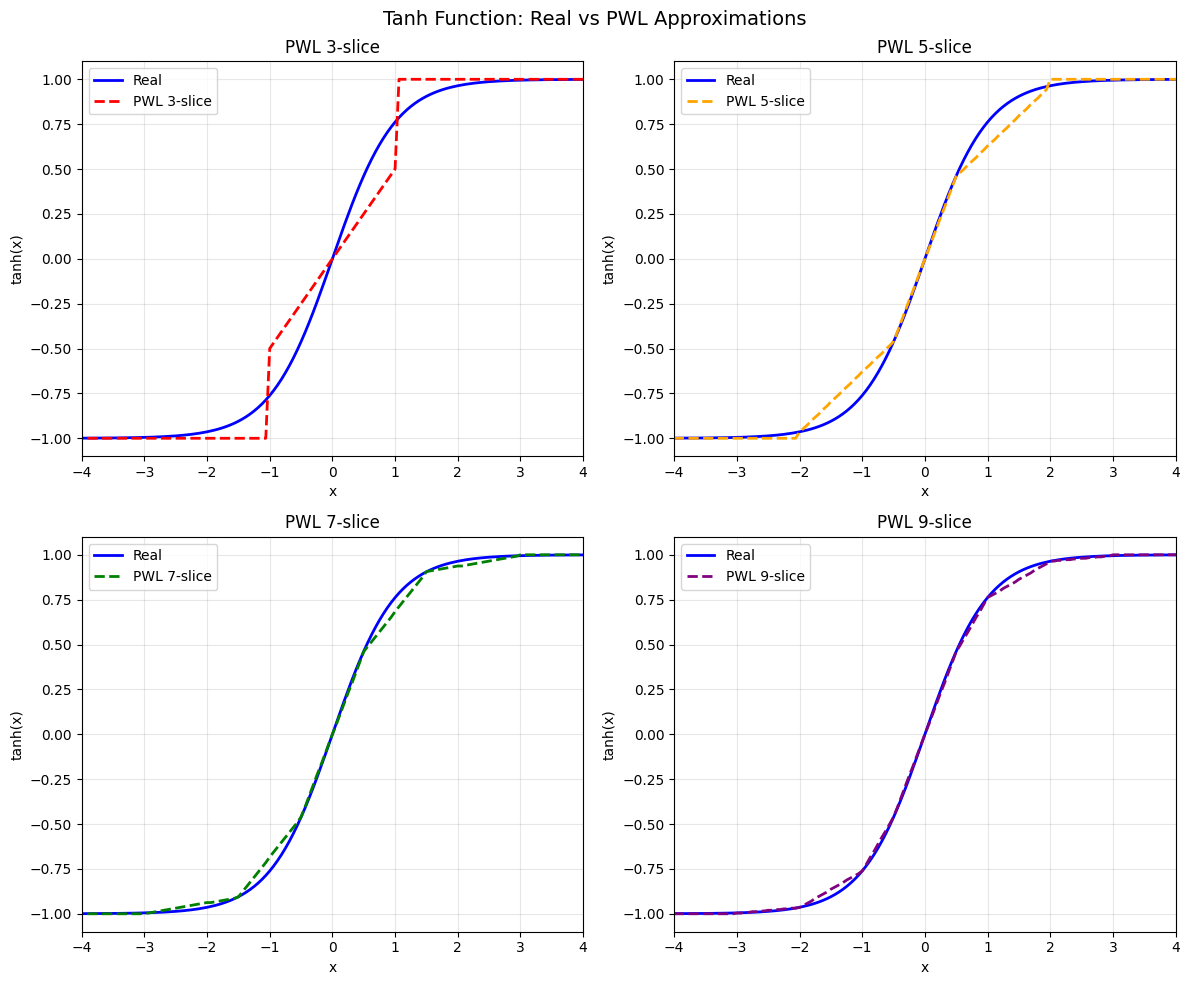

In [41]:
# Tanh comparison (2x2 grid)
plot_result_2(
    ref_path='data/output_reference.csv',
    out_paths=[
        ('PWL 3-slice', 'data/output_pwl_tanh_3.csv'),
        ('PWL 5-slice', 'data/output_pwl_tanh_5.csv'),
        ('PWL 7-slice', 'data/output_pwl_tanh_7.csv'),
        ('PWL 9-slice', 'data/output_pwl_tanh_9.csv'),
    ],
    mode='tanh',
    xlim=(-4, 4)
)

In [36]:
# Generate combined CSV with all results

def generate_combined_csv(output_path='data/combined_results.csv'):
    """
    Combine all input, reference, and PWL outputs into one tidy CSV.
    """
    # Load reference
    ref = pd.read_csv('data/output_reference.csv')
    
    # Start with x and reference values
    combined = pd.DataFrame({
        'x': ref['x'],
        'sigmoid_ref': ref['sigmoid'],
        'tanh_ref': ref['tanh']
    })
    
    # Load all sigmoid PWL outputs
    for n in [3, 5, 7, 9]:
        try:
            pwl = pd.read_csv(f'data/output_pwl_sigmoid_{n}.csv')
            combined[f'sigmoid_pwl_{n}'] = pwl['y_out'] / 256.0
        except FileNotFoundError:
            print(f'Warning: output_pwl_sigmoid_{n}.csv not found')
    
    # Load all tanh PWL outputs
    for n in [3, 5, 7, 9]:
        try:
            pwl = pd.read_csv(f'data/output_pwl_tanh_{n}.csv')
            combined[f'tanh_pwl_{n}'] = pwl['y_out'] / 256.0
        except FileNotFoundError:
            print(f'Warning: output_pwl_tanh_{n}.csv not found')
    
    # Save to CSV
    combined.to_csv(output_path, index=False, float_format='%.6f')
    print(f'Saved combined results to {output_path}')
    print(f'Shape: {combined.shape}')
    print(f'Columns: {list(combined.columns)}')
    
    return combined

# Generate the combined CSV
combined = generate_combined_csv()
combined.head(10)

Saved combined results to data/combined_results.csv
Shape: (257, 11)
Columns: ['x', 'sigmoid_ref', 'tanh_ref', 'sigmoid_pwl_3', 'sigmoid_pwl_5', 'sigmoid_pwl_7', 'sigmoid_pwl_9', 'tanh_pwl_3', 'tanh_pwl_5', 'tanh_pwl_7', 'tanh_pwl_9']


,x,sigmoid_ref,tanh_ref,sigmoid_pwl_3,sigmoid_pwl_5,sigmoid_pwl_7,sigmoid_pwl_9,tanh_pwl_3,tanh_pwl_5,tanh_pwl_7,tanh_pwl_9
0,-8.0000,0.000335,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
1,-7.9375,0.000357,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
2,-7.8750,0.000380,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
3,-7.8125,0.000404,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
4,-7.7500,0.000431,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
5,-7.6875,0.000458,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
6,-7.6250,0.000488,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
7,-7.5625,0.000519,-0.999999,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
8,-7.5000,0.000553,-0.999999,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
9,-7.4375,0.000588,-0.999999,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0


/tmp/ipykernel_34498/3273672283.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, y, 'b-', color=colors[i % len(colors)], label=label, linewidth=2)


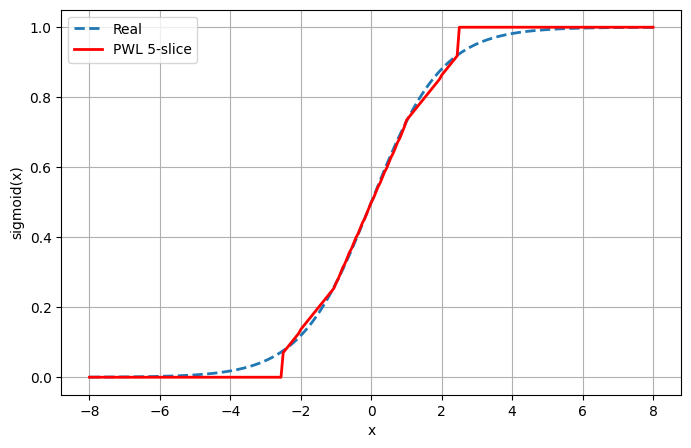

In [51]:
# Sigmoid
plot_result(
    ref_path='data/output_reference.csv',
    out_paths=[
        ('PWL 5-slice', 'data/output_pwl_sigmoid_5_opt.csv'),
    ],
    mode='sigmoid'
)

/tmp/ipykernel_34498/3273672283.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, y, 'b-', color=colors[i % len(colors)], label=label, linewidth=2)


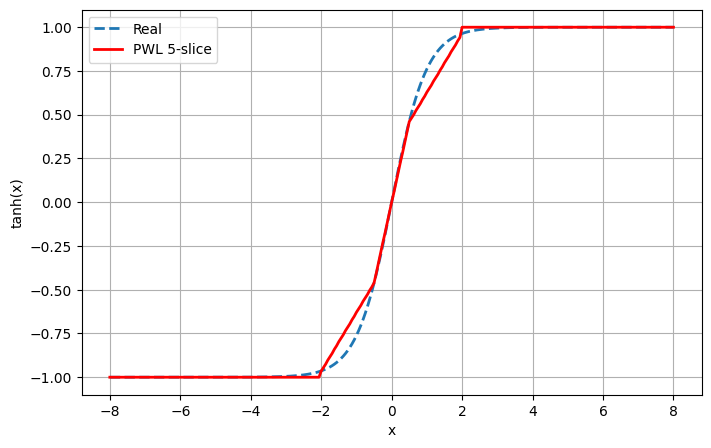

In [ ]:
# Tanh
plot_result(
    ref_path='data/output_reference.csv',
    out_paths=[
        ('PWL 5-slice', 'data/output_pwl_tanh_5_opt.csv'),
    ],
    mode='tanh',
    xlim=(-4, 4)
)